# Chapter 3 - Distributions

- We can use the `Pmf` (probability mass function) to solve some problems
- PMF maps from outcomes to probabilities

In [1]:
from empiricaldist import Pmf

coin = Pmf()
coin['heads'] = 1/2
coin['tails'] = 1/2
coin

,probs
heads,0.5
tails,0.5


In [2]:
die = Pmf.from_seq([1, 2, 3, 4, 5, 6])
die

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


In [3]:
letters = Pmf.from_seq(list("Mississippi"))
letters

,probs
M,0.090909
i,0.363636
p,0.181818
s,0.363636


You can ask for `letters['t']`, but this will throw an error. On the other hand, asking for `letters('t')` will give you zero.

In [4]:
die([1, 4, 7])

array([0.16666667, 0.16666667, 0.        ])

`Pmf` inherits from pandas `Series`, so you can do anything with a `Pmf` you can do with a `Series`.

## The Cookie Problem Revisited

> Cookie problem again.
> 
> Bowl 1: 30 vanilla, 10 chocolate
> Bowl 2: 20 vanilla, 20 chocolate

In [5]:
prior = Pmf.from_seq(['Bowl 1', "Bowl 2"])
prior

,probs
Bowl 1,0.5
Bowl 2,0.5


This is actually a distribution - the *prior distribution*.

In [6]:
likelihood_vanilla = [0.75, 0.5]
posterior = prior * likelihood_vanilla
posterior.normalize()
posterior

,probs
Bowl 1,0.6
Bowl 2,0.4


This is another probability distribution - the *posterior distribution*.

In [7]:
posterior('Bowl 1')

0.6

One advantage of this method: it is easy to update with additional data. 

Let's say that you put the cookie back, and draw again from the same bowl. Again, you get a vanilla cookie. Now what is the probability that it was Bowl 1?

In [8]:
posterior *= likelihood_vanilla
posterior.normalize()
posterior

,probs
Bowl 1,0.692308
Bowl 2,0.307692


Now let's say you do the same thing, but this time you get a chocolate cookie!

In [9]:
likelihood_chocolate = [0.25, 0.5]

posterior *= likelihood_chocolate
posterior.normalize()
posterior

,probs
Bowl 1,0.529412
Bowl 2,0.470588


## 101 Bowls

> Let's solve a related problem with 100 bowls:
> - Bowl 0 contains 0% vanilla
> - Bowl 1 contains 1% vanilla
> - Bowl 2 contains 2% vanilla
> - ...
> - Bowl 100 contains 100% vanilla
> Suppose we choose a bowl and a cookie at random, and it is vanilla. What is the probability that it came from Bowl $x$, for each value of $x$?

In [10]:
import numpy as np

hypos = np.arange(101) #creates a sequence of 0 - 100

prior = Pmf(1, hypos) # 1st parameter is the prior probability (uniform distribution), 2nd is the sequence of quantities
prior.normalize()
prior.head()

,probs
0,0.009901
1,0.009901
2,0.009901


In [11]:
likelihood_vanilla = hypos / 100
likelihood_vanilla[:5]

array([0.  , 0.01, 0.02, 0.03, 0.04])

In [12]:
posterior1 = prior * likelihood_vanilla
posterior1.normalize()
posterior1.head()

,probs
0,0.000000
1,0.000198
2,0.000396


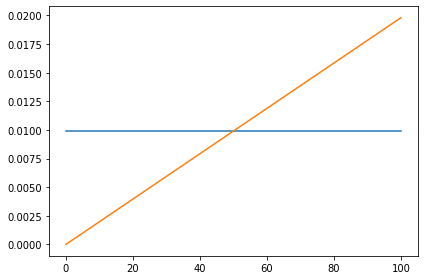

In [13]:
import matplotlib.pyplot as plt

prior.plot(label="Prior")
posterior1.plot(label="Posterior")
plt.tight_layout()


(Straight line is the priors - sloped one is the posteriors)

Now let's say that we again draw a cookie from the same bowl, and again it is vanilla.

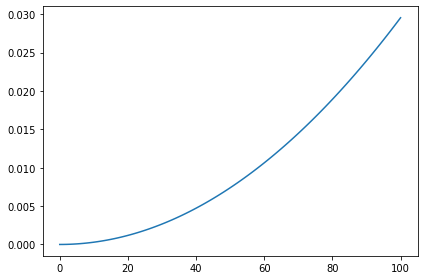

In [14]:
posterior2 = posterior1 * likelihood_vanilla
posterior2.normalize()

plt.clf()
posterior2.plot()
plt.tight_layout()

Now let's say that we again draw from the same bowl, but this time we get chocolate.

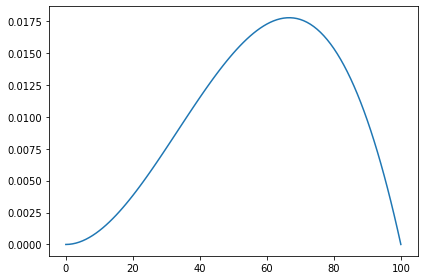

In [15]:
likelihood_chocolate = 1 - hypos / 100
posterior3 = posterior2 * likelihood_chocolate
posterior3.normalize()

plt.clf()
posterior3.plot()
plt.tight_layout()

We now have a quite different distribution! The peak is at bowl 67, which is basically the data that we have (2 vanilla, 1 chocolate -> 2/3). This is called the MAP ("maximum a posteriori probability"). We can calculate it using either the `Series` `idxmax` function or the `Pmf` `max_prob` function.

In [16]:
print(f"posterior3.idxmax(): {posterior3.idxmax()}")
print(f"posterior3.max_prob(): {posterior3.max_prob()}")

posterior3.idxmax(): 67
posterior3.max_prob(): 67


## The Dice Problem

> D6, D8, D12. Choose one and roll it; result is 1. What is the probability that I chose the D6?

In [17]:
hypos = [6, 8, 12]
prior = Pmf(1/3, hypos) # recall: priors, hypotheses
prior

,probs
6,0.333333
8,0.333333
12,0.333333


`Pmf` has two attribtues:
- `qs`: quantities in the distribution
- `ps`: probabilities in the distribution

In [18]:
print(f"prior.qs: {prior.qs}")
print(f"prior.ps: {prior.ps}")

prior.qs: [ 6  8 12]
prior.ps: [0.33333333 0.33333333 0.33333333]


In [19]:
likelihood1 = (1/6, 1/8, 1/12)
posterior = prior * likelihood1
posterior.normalize()
posterior

,probs
6,0.444444
8,0.333333
12,0.222222


Now suppose I roll it again and get a 7. Now what?

In [20]:
likelihood2 = (0, 1/8, 1/12)

posterior *= likelihood2
posterior.normalize()
posterior

,probs
6,0.000000
8,0.692308
12,0.307692


## Updating Dice

We can generalize this process:

In [21]:
def update_dice(pmf, data):
    """ Update pmf based on new data """
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = data > hypos
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()
    
    
# In action
pmf = prior.copy()
pmf

,probs
6,0.333333
8,0.333333
12,0.333333


In [22]:
update_dice(pmf, 1)
update_dice(pmf, 7)
pmf

,probs
6,0.000000
8,0.692308
12,0.307692


Same results!

## Exercises

### Exercise 3-1
> Suppose I have a box with a D6, a D8, and a D12. I choose one die at random, roll it 4 times, and get 1, 3, 5, 7. What is the probability that it was the D8?

In [23]:
hypos = [6, 8, 12]
priors = Pmf.from_seq(hypos)
pmf = priors.copy()
for result in [1, 3, 5, 7]:
    update_dice(pmf, result)
pmf

,probs
6,0.000000
8,0.835052
12,0.164948


### Exercise 3-2
> In the previous version of the Dice Problem, the prior probabilities are the same because the box contains one of each die. Now suppose that the box contains 1 D4, 2D6, 3 D8, 4 D12, and 5 D20. I choose a die, roll it, and get a 7. What is that probability that I chose a D8?
> Hint: To make the prior distribution, call Pmf with two parameters.

In [24]:
from fractions import Fraction
hypos = ["D4", "D6", "D8", "D12", "D20"]
total_dice = 1 + 2 + 3 + 4 + 5
priors = Pmf(( Fraction(n, total_dice) for n in range(1, 6)), hypos)
likelihood = [
    0,
    0,
    Fraction(1, 8),
    Fraction(1, 12),
    Fraction(1, 20),
]
pmf = priors * likelihood
pmf.normalize()
pmf

,probs
D4,0
D6,0
D8,9/23
D12,8/23
D20,6/23


So the probability that it was one of the D8s is 8/23.

### Exercise 3-3
> Two sock drawers. One has equal numbers of black and white socks. The other has equal numbers of red, green, and blue socks. Suppose that I choose a drawer at random, choose two socks at random, and get a matching pair. What is the probability that the socks are white?
>
> For simplicity, let's assume that there are so many socks in both drawers that removing one sock makes a negligible change to the proportions.

Data: there is a pair

Hypotheses: The drawer from which the socks were drawn
(Drawer 1: Black and White; Drawer 2: Red, Green, Blue)

In [25]:
hypos = ["Drawer 1", "Drawer 2"]
priors = Pmf(Fraction(1,2), hypos)
likelihood = (Fraction(1,2), Fraction(1,3))
posterior = priors * likelihood
posterior.normalize()
posterior

,probs
Drawer 1,3/5
Drawer 2,2/5


$$
\begin{aligned}
    P(\text{White pair}) &= P(\text{Drawer 1}) * P(\text{White} | \text{Drawer 1}) \\
                   &= (3/5) * (1/2) \\
                   &= 3/10
\end{aligned}
$$

### Exercise 3-4
> (From *Bayesion Data Analysis*)
>
>> Elvis has a twin brother who died at birth. What is the probability that he was an identical twin?
>
> Hint: in 1935 about 2/3 or twins were fraternal and 1/3 were identical.

We know that Elvis had a twin *brother*. If he was an identical twin, then of course his twin would be a brother. If he was a fraternal twin, then there is a 50/50 chance of it being a brother.

In [26]:
hypos = ["Fraternal", "Identical"]
probs = (Fraction(2, 3), Fraction(1, 3))
priors = Pmf(probs, hypos)
likelihood = [Fraction(1, 2), 1]
posterior = priors * likelihood
posterior.normalize()
posterior

,probs
Fraternal,1/2
Identical,1/2


So there is a 50% chance that Elvis was an identical twin.